In [1]:
import os
import json
from model_functions import PaddedDataset, trainer_gpt2_transformer, analyze_token_sequence

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import GPT2Config, GPT2Tokenizer, GPT2LMHeadModel, DataCollatorForLanguageModeling, TrainingArguments, Trainer


PATH_VOCAB = "../0_data/5_vocabs"
PATH_WORD_DATA = "../0_data/6_word_data"
PATH_MODELS = "../0_data/7_models"
PATH_MODELS_LOSS = "../0_data/7_models/loss"
PATH_MODELS_CONFIG = "../0_data/7_models/config"

for path in [PATH_MODELS, PATH_MODELS_LOSS, PATH_MODELS_CONFIG]:
    if not os.path.exists(path):
        os.makedirs(path)

: 

: 

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Data

In [3]:
with open('data_words.json', 'r') as fp:
    json_data = json.load(fp)

song_list = []
for song in json_data:
    song_list.append(json_data[song])

data = [" ".join(song) for song in song_list]

split_train_test = int(0.9*len(data))
print("Data length:", len(data))
print("90% at:     ", split_train_test)
print()
print("Example data point:", data[0][:60])

Data length: 803
90% at:      722

Example data point: Bar_None Position_3/16 Note-On_76 Note-Duration_2 Position_4


# Tokeinzer

In [4]:
tokenizer = GPT2Tokenizer(
    vocab_file="vocab.json", 
    merges_file="merges.txt")

tokenizer.add_special_tokens({'pad_token': 'PAD', 'bos_token': 'BOS', 'eos_token': 'EOS',})

print("vocab size: ", tokenizer.vocab_size)
print("PAD token: ", tokenizer.pad_token_id)
print("BOS token: ", tokenizer.bos_token_id)
print("EOS token: ", tokenizer.eos_token_id)

vocab size:  120
PAD token:  120
BOS token:  121
EOS token:  122


# Model

In [5]:
model_df = pd.read_excel("model_stats_preprocessed.xlsx", index_col="Unnamed: 0")
model_df

,name,max_length,emb_dim,attention_heads,layers,dropout,learning_rate,epochs,batch_size,ran,runtime,runtime_min,min_loss,at_epoch,incorrect_notes,correct_notes,correct_rate
0,1_short_small_50,256,128,2,3,0.01,0.001,50,4,yes,185.8307,3.1,1.162286,46,NaN,NaN,NaN
1,2_short_medium_50,256,256,4,6,0.01,0.001,50,4,yes,304.2706,5.07,1.208278,30,NaN,NaN,NaN
2,3_short_large_50,256,512,8,12,0.01,0.001,50,4,yes,559.9953,9.33,1.841974,48,NaN,NaN,NaN
3,4_middle_small_50,1024,128,2,3,0.01,0.001,50,4,yes,241.443,4.02,1.09383,50,NaN,NaN,NaN
4,5_middle_medium_50,1024,256,4,6,0.01,0.001,50,4,yes,614.6323,10.24,1.120662,37,NaN,NaN,NaN
5,6_middle_large_50,1024,512,8,12,0.01,0.001,50,4,yes,2237.4356,37.29,1.883723,49,NaN,NaN,NaN
6,7_long_small_50,2048,128,2,3,0.01,0.001,50,4,yes,482.1712,8.04,1.120337,49,NaN,NaN,NaN
7,8_long_medium_50,2048,256,4,6,0.01,0.001,50,4,yes,1494.6219,24.91,1.156429,35,NaN,NaN,NaN
8,9_long_large_50,2048,512,8,12,0.01,0.001,50,4,yes,too big - cuda error,too big - cuda error,too big - cuda error,too big - cuda error,NaN,NaN,NaN


In [6]:
rows = []

for index, row in model_df.iterrows():
    
    # only run models that not ran yet
    if row["ran"] == "yes":
        continue
    
    # create model name directories
    model_name = row["name"]
    model_dirs = {
        "logging": f"logs/{model_name}",
        "out": f"out/{model_name}"
    }
    for key in model_dirs:
        if not os.path.exists(model_dirs[key]):
            os.makedirs(model_dirs[key])
    
    # save hyperparameters as dictionary
    model_hyperparameters = {
        "max_length": row["max_length"],
        "emb_dim": row["emb_dim"],
        "attention_heads": row["attention_heads"],
        "layers": row["layers"],
        "dropout": row["dropout"],
        "learning_rate": row["learning_rate"],
        "epochs": row["epochs"],
        "batch_size": row["batch_size"],
    }
    
    # create datasets and define data collator
    train_dataset = PaddedDataset(tokenizer=tokenizer, data=data[:split_train_test], max_length=row["max_length"])
    eval_dataset = PaddedDataset(tokenizer=tokenizer, data=data[split_train_test:], max_length=row["max_length"])
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
    model_data = {
        "train_dataset": train_dataset,
        "eval_dataset": eval_dataset,
        "data_collator": data_collator,
    }
    
    # create and train model trainer
    trainer = trainer_gpt2_transformer(
        hyperparameters = model_hyperparameters,
        tokenizer = tokenizer,
        data = model_data,
        dirs = model_dirs,
    )
    
    trainer.train()
    
    
    # save runtime and model loss
    log_hist = trainer.state.log_history
    eval_loss = [log_hist[i]["eval_loss"] for i in range(1,len(log_hist),2)]
    train_loss = [log_hist[i]["loss"] for i in range(0,len(log_hist)-1,2)]
    runtime = log_hist[-1]["train_runtime"]
    
    model_df.at[index,"runtime"] = runtime
    model_df.at[index,"runtime_min"] = (runtime/60).__round__(2)
    model_df.at[index,"min_loss"] = min(eval_loss)
    model_df.at[index,"at_epoch"] = np.argmin(eval_loss) + 1

    # show loss plot
    plt.plot(train_loss, color="blue")
    plt.plot(eval_loss, color="orange")
    plt.savefig(f"{model_dirs['logging']}/loss_graph_{model_name}.jpg")
    plt.show()
    
    # save model and set ran to yes
    trainer.save_model(f"{model_dirs['out']}/end_version")
    model_df.at[index,"ran"] = "yes"
    
model_df

,name,max_length,emb_dim,attention_heads,layers,dropout,learning_rate,epochs,batch_size,ran,runtime,runtime_min,min_loss,at_epoch,incorrect_notes,correct_notes,correct_rate
0,1_short_small_50,256,128,2,3,0.01,0.001,50,4,yes,185.8307,3.1,1.162286,46,NaN,NaN,NaN
1,2_short_medium_50,256,256,4,6,0.01,0.001,50,4,yes,304.2706,5.07,1.208278,30,NaN,NaN,NaN
2,3_short_large_50,256,512,8,12,0.01,0.001,50,4,yes,559.9953,9.33,1.841974,48,NaN,NaN,NaN
3,4_middle_small_50,1024,128,2,3,0.01,0.001,50,4,yes,241.443,4.02,1.09383,50,NaN,NaN,NaN
4,5_middle_medium_50,1024,256,4,6,0.01,0.001,50,4,yes,614.6323,10.24,1.120662,37,NaN,NaN,NaN
5,6_middle_large_50,1024,512,8,12,0.01,0.001,50,4,yes,2237.4356,37.29,1.883723,49,NaN,NaN,NaN
6,7_long_small_50,2048,128,2,3,0.01,0.001,50,4,yes,482.1712,8.04,1.120337,49,NaN,NaN,NaN
7,8_long_medium_50,2048,256,4,6,0.01,0.001,50,4,yes,1494.6219,24.91,1.156429,35,NaN,NaN,NaN
8,9_long_large_50,2048,512,8,12,0.01,0.001,50,4,yes,too big - cuda error,too big - cuda error,too big - cuda error,too big - cuda error,NaN,NaN,NaN


In [7]:
model_df.to_excel("model_stats.xlsx")

## Sequential Version

In [5]:
# create datasets and data collator
train_dataset = PaddedDataset(tokenizer=tokenizer, data=data[:split_train_test], max_length=32)
eval_dataset = PaddedDataset(tokenizer=tokenizer, data=data[split_train_test:], max_length=32)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [6]:
# define GPT-2 model architecture
config = GPT2Config(
    vocab_size=tokenizer.vocab_size,
    n_positions=128, # max seq length
    n_embd=128,
    n_head=4, 
    n_layer=6,
    dropout=0.01 
)
model = GPT2LMHeadModel(config)

In [7]:
# define training arguments
training_args = TrainingArguments(
    output_dir="test_out",
    overwrite_output_dir=True,
    num_train_epochs=30,
    per_device_train_batch_size=4,
    save_steps=1000,
    save_total_limit=5,
    learning_rate=1e-4,
    #weight_decay=0.01,
    #warmup_steps=1_000,
    logging_dir="test_log",
    logging_steps=100,
    seed=4711,
    evaluation_strategy="epoch",
    logging_strategy="epoch"
)

# create and train Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

training = trainer.train()
training

/home/jlauten_ext/PyEnv/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,3.346700,2.700208
2,2.412300,2.259674
3,2.096000,2.041030
4,1.926700,1.881823
5,1.795400,1.773080
6,1.702600,1.682822
7,1.630400,1.613042
8,1.581100,1.569922
9,1.534600,1.538607
10,1.504600,1.513601


TrainOutput(global_step=5430, training_loss=1.5551064085565218, metrics={'train_runtime': 167.7591, 'train_samples_per_second': 129.114, 'train_steps_per_second': 32.368, 'total_flos': 4948411023360.0, 'train_loss': 1.5551064085565218, 'epoch': 30.0})

Seconds:  167.7591
Minutes:  2.8


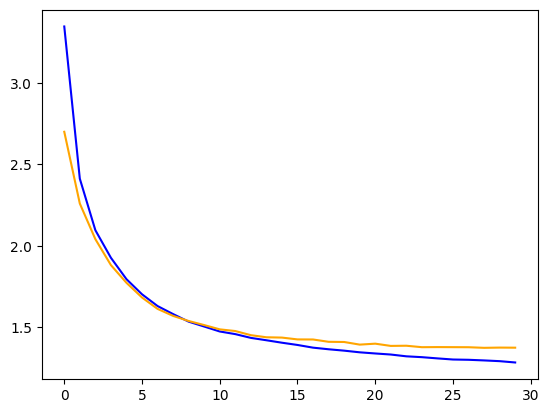

In [8]:
log_hist = trainer.state.log_history
eval_loss = [log_hist[i]["eval_loss"] for i in range(1,len(log_hist),2)]
train_loss = [log_hist[i]["loss"] for i in range(0,len(log_hist)-1,2)]
runtime = log_hist[-1]["train_runtime"]

print("Seconds: ", runtime)
print("Minutes: ", (runtime/60).__round__(2))

plt.plot(train_loss, color="blue")
plt.plot(eval_loss, color="orange")
plt.show()

In [9]:
inputs = tokenizer.encode("Bar_None".split(" "), return_tensors="pt")
inputs = inputs.to(device)

#outputs = model.generate(inputs, max_length=100, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
outputs = model.generate(inputs, max_length=20, temperature=0.8)
outputs

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[  0, 103, 118,   8,  40, 105,   8,  44, 101, 107, 118,   8,  44, 101,
         108, 119,   8,  44, 101, 111]], device='cuda:0')

In [10]:
tokenizer.decode(outputs[0], skip_special_tokens=False)

'Bar_NonePosition_2/16Position-Triole_1Note-On_67Note-Duration_4Position_4/16Note-On_67Note-Duration_8Note-Duration_triolePosition_6/16Position-Triole_1Note-On_67Note-Duration_8Note-Duration_triolePosition_7/16Position-Triole_2Note-On_67Note-Duration_8Note-Duration_triolePosition_10/16'

In [11]:
#trainer.save_model("gpt_models/model1")

In [12]:
######## Andere Variante ########

In [13]:
outputs = model(inputs)
outputs.logits.shape

torch.Size([1, 1, 120])

In [14]:
outputs.logits

tensor([[[ 1.1162, -2.1350, -3.5313, -1.9780, -3.5414, -1.5776, -1.8704,
          -3.5441, -1.1535, -2.6672, -0.8764, -2.2812, -1.6335, -0.8708,
          -2.7905, -1.4720, -2.4843, -0.5825, -2.0775, -2.7744, -1.5724,
          -3.7235, -1.8095, -2.4802, -2.3428, -2.3748, -3.2765, -2.9800,
          -3.1671, -2.6769, -3.6342, -3.3965, -2.9433, -3.3021, -3.6102,
          -3.8760, -3.8078, -2.8941, -0.2965, -3.4592, -0.6409, -3.7882,
          -1.4499, -3.6240, -0.8940, -3.3144, -1.9948, -3.0505, -2.1582,
          -3.2950, -2.2917, -3.4952, -1.5516, -3.7166, -2.3756, -3.3413,
          -2.5331, -3.7758, -2.4212, -3.4614, -2.8825, -3.7335, -2.9825,
          -2.8619, -2.9172, -3.3198, -3.0439, -2.9400, -1.7772, -3.4107,
          -3.0528, -3.1332, -3.2200, -3.2291, -2.9769, -3.1939, -1.9817,
          -2.9937, -2.8389, -3.1996, -2.9903, -2.9885, -3.7754, -3.6936,
          -3.1062, -3.3149, -3.9010, -3.4983, -3.7158, -3.4427, -3.5639,
          -3.5325, -1.8639, -3.7709, -3.4870, -3.22

In [15]:
# Temperature value
temperature = 13

# Convert logits to probabilities using softmax with temperature
probs = F.softmax(outputs.logits / temperature, dim=-1)

# Sample a token from the probability distribution for each position in the sequence
predicted_tokens = torch.multinomial(probs.view(-1, probs.shape[-1]), num_samples=1).view(*probs.shape[:-1])
predicted_tokens

tensor([[24]], device='cuda:0')

In [16]:
tokenizer.decode(predicted_tokens[0], skip_special_tokens=False)

'Note-On_83'